# Get the weather in germany and plot it

Getting the weather of germany via the api of the german weather service (DWD) and plot it.

## Import everything important

In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import folium
from sklearn.cluster import KMeans
import requests
import json
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np
from scipy.spatial import cKDTree
from scipy.signal import convolve2d
import geopandas as gpd
from shapely.geometry import Polygon, Point
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs

## Get the points which are inside germany

### Get outline of germany

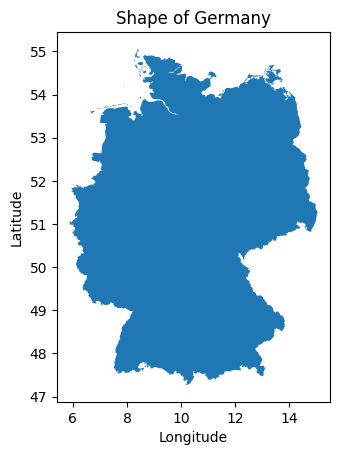

In [7]:
# get the outline of germany and print it
def get_germany(plot=False):
    gpkg_file = "resources/gadm36_DEU_gpkg/gadm36_DEU.gpkg"

    # Read the GeoPackage file
    germany_shape = gpd.read_file(gpkg_file)

    # Plot the shape of Germany
    if(plot):
        germany_shape.plot()
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('Shape of Germany')
        plt.show()

    return germany_shape

germany_shape = get_germany(True)

### Make a rectangle grid of points which the size of germany

the following code takes a very long time (about 2 hours)

In [8]:



def getPoints(xmin, xmax, ymin, ymax, resolution):
    x = np.arange(xmin, xmax, resolution)
    y = np.arange(ymin, ymax, resolution)
    xx, yy = np.meshgrid(x, y)
    return np.vstack([xx.ravel(), yy.ravel()]).T

def getGermanyPoints():
    # Get the outline of Germany
    germany_shape = get_germany()

    # Get the bounding box of Germany
    xmin, ymin, xmax, ymax = germany_shape.total_bounds

    print("Bounding box of Germany: ", xmin, ymin, xmax, ymax)

    # Get the points inside the germany_shape polygon
    points = getPoints(xmin, xmax, ymin, ymax, 0.025) # 0.1 was 7 min
    point_geometries = [Point(x, y) for x, y in points]

    points_inside_germany = []
    for point in point_geometries:
        if germany_shape.geometry.contains(point).any():
            points_inside_germany.append(point)

    return points_inside_germany

germany_points = getGermanyPoints()

Bounding box of Germany:  5.86625051 47.27012253 15.0418148 55.05652618


In [9]:
# make array of tuples for easier use later
germany_points = np.array([point.coords[0] for point in germany_points])

# save germany_points to txt file for easier use later
np.savetxt('resources/germany_points.txt', germany_points)

loading the points which are inside germany from a file

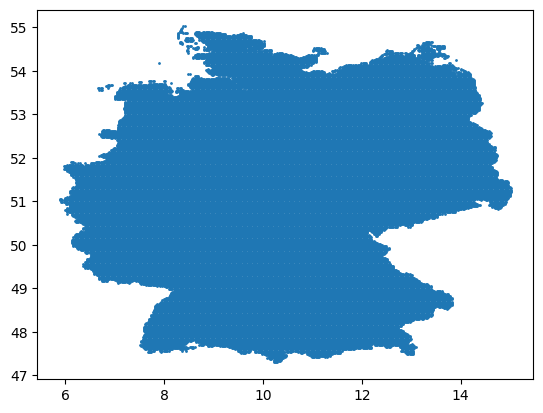

In [4]:
# load the points from the txt file
germany_points = np.loadtxt('resources/germany_points.txt')

# plot the points
plt.scatter(germany_points[:, 0], germany_points[:, 1], s=1)

## Get the weather data

### get the station ids from the html website

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'

# Read HTML content from file
with open('./resources/station_ids.html', 'r', encoding='utf-8') as file:
    html = file.read()

# Parse HTML
soup = BeautifulSoup(html, 'html.parser')

# Find the table
table = soup.find('table')

# Extract table headers
headers = [header.text.strip() for header in table.find_all('th')][1:]

# print(headers)

# Extract table rows
data = []
for row in table.find_all('tr')[1:]:
    row_data = [cell.text.strip() for cell in row.find_all('td')]
    # print(row_data)
    if(row_data != []):
        data.append(row_data)

# Create DataFrame
df = pd.DataFrame(data, columns=headers)

# delete rows, where the string in column "Ende" doesnt include "2024"
df = df[~df['Ende'].str.contains('2024')]

### filter the station ids dataframe

In [7]:
# get just the first two columns (Stationsname and Stations_id)
df_important = df[['Stationsname', 'Stations_ID', 'Stations-kennung', 'Breite', 'Länge']]

# delete all duplicated rows
df_important.drop_duplicates(subset='Stationsname', keep='first', inplace=True)

### request the weather data from the DWD api

In [8]:
url = 'https://dwd.api.proxy.bund.dev/v30/stationOverviewExtended'

headers_request = {
    'Accept': 'application/json'
}

# for each row get the Stations-kennung data
stations_kennung = df['Stations-kennung'].tolist()

stations_kennung = ','.join(stations_kennung)

# split it in parts of 500
stations_kennung = [stations_kennung[i:i + 500] for i in range(0, len(stations_kennung), 500)]

print(stations_kennung)

# # use the list to make an API request to get the data for each station
all_responses = {}
for stations in stations_kennung:
    params = {
        'stationIds': stations
    }
    response = requests.get(url, headers=headers_request, params=params)
    data = response.json()
    for station, content in data.items():
        # print(content) 
        all_responses[station] = content

['02783,70191,10771,02205,02205,02205,02205,10501,80310,02205,10501,02205,80313,19703,80316,8930,10503,8931,71501,76352,76351,91404,54336,44429,32135,73206,11207,90674,75115,11672,8373,7699,92564,13118,71151,8043,54365,92422,71524,10324,11646,73448,Q059,71645,10538,10778,93162,K242,85444,K242,9934,48437,54838,7979,8602,44530,13106,71575,43302,12953,9712,8922,10823,52437,11522,7892,90593,9713,8348,10594,8999,33102,9008,56145,8333,9231,20010,8125,7904,9010,31102,60224,8349,8560,8603,51505,7952,91414', ',10541,Q153,71639,Q153,73379,04013,9937,15019,54121,03874,03874,03874,48553,03874,03874,27036,7536,8633,12208,12636,30130,8350,8972,10087,10978,90632,10964,11486,90277,11827,10347,90667,11223,90370,04502,91440,70252,13160,92375,11133,9050,10797,9535,30361,7802,91171,11906,11100,10242,13612,42524,13309,02928,02928,Q751,71039,02928,Q751,02928,71038,02755,90129,02926,02926,02926,90128,02926,8814,04519,90722,71208,71523,7980,54668,13922,9982,9148,51159,11550,9315,51241,9479,10695,56007,54033,7

In [52]:
forecast1StationId = []
forecast1Start = []
forecast1TimeStep = []
forecast1Temperature = []
forecast1WindSpeed = []
forecast1WindDirection = []
forecast1WindGust = []
forecast1PrecipitationTotal = []
forecast1Sunshine = []
forecast1DewPoint2m = []
forecast1SurfacePressure = []
forecast1Humidity = []
forecast1IsDay = []
forecast1CloudCoverTotal = []
forecast1TemperatureStd = []
forecast1Icon = []
forecast1Icon1h = []
forecast1PrecipitationProbablity = []
forecast1PrecipitationProbablityIndex = []

forecast2StationId = []
forecast2Start = []
forecast2TimeStep = []
forecast2Temperature = []
forecast2WindSpeed = []
forecast2WindDirection = []
forecast2WindGust = []
forecast2PrecipitationTotal = []
forecast2Sunshine = []
forecast2DewPoint2m = []
forecast2SurfacePressure = []
forecast2Humidity = []
forecast2IsDay = []
forecast2CloudCoverTotal = []
forecast2TemperatureStd = []
forecast2Icon = []
forecast2Icon1h = []
forecast2PrecipitationProbablity = []
forecast2PrecipitationProbablityIndex = []

for key, value in all_responses.items():
    forecast1 = value['forecast1']
    forecast2 = value['forecast2']
    
    if forecast1['stationId']:
        forecast1StationId.append(forecast1['stationId'])
    if forecast1['start']:
        forecast1Start.append(forecast1['start'])
    if forecast1['timeStep']:
        forecast1TimeStep.append(forecast1['timeStep'])
    if forecast1['temperature']:
        forecast1Temperature.append(forecast1['temperature'])
    if forecast1['windSpeed']:
        forecast1WindSpeed.append(forecast1['windSpeed'])
    if forecast1['windDirection']:
        forecast1WindDirection.append(forecast1['windDirection'])
    if forecast1['windGust']:
        forecast1WindGust.append(forecast1['windGust'])
    if forecast1['precipitationTotal']:
        forecast1PrecipitationTotal.append(forecast1['precipitationTotal'])
    if forecast1['sunshine']:
        forecast1Sunshine.append(forecast1['sunshine'])
    if forecast1['dewPoint2m']:
        forecast1DewPoint2m.append(forecast1['dewPoint2m'])
    if forecast1['surfacePressure']:
        forecast1SurfacePressure.append(forecast1['surfacePressure'])
    if forecast1['humidity']:
        forecast1Humidity.append(forecast1['humidity'])
    if forecast1['isDay']:
        forecast1IsDay.append(forecast1['isDay'])
    if forecast1['cloudCoverTotal']:
        forecast1CloudCoverTotal.append(forecast1['cloudCoverTotal'])
    if forecast1['temperatureStd']:
        forecast1TemperatureStd.append(forecast1['temperatureStd'])
    if forecast1['icon']:
        forecast1Icon.append(forecast1['icon'])
    if forecast1['icon1h']:
        forecast1Icon1h.append(forecast1['icon1h'])
    if forecast1['precipitationProbablity']:
        forecast1PrecipitationProbablity.append(forecast1['precipitationProbablity'])
    if forecast1['precipitationProbablityIndex']:
        forecast1PrecipitationProbablityIndex.append(forecast1['precipitationProbablityIndex'])

    if forecast2['stationId']:
        forecast2StationId.append(forecast2['stationId'])
    if forecast2['start']:
        forecast2Start.append(forecast2['start'])
    if forecast2['timeStep']:
        forecast2TimeStep.append(forecast2['timeStep'])
    if forecast2['temperature']:
        forecast2Temperature.append(forecast2['temperature'])
    if forecast2['windSpeed']:
        forecast2WindSpeed.append(forecast2['windSpeed'])
    if forecast2['windDirection']:
        forecast2WindDirection.append(forecast2['windDirection'])
    if forecast2['windGust']:
        forecast2WindGust.append(forecast2['windGust'])
    if forecast2['precipitationTotal']:
        forecast2PrecipitationTotal.append(forecast2['precipitationTotal'])
    if forecast2['sunshine']:
        forecast2Sunshine.append(forecast2['sunshine'])
    if forecast2['dewPoint2m']:
        forecast2DewPoint2m.append(forecast2['dewPoint2m'])
    if forecast2['surfacePressure']:
        forecast2SurfacePressure.append(forecast2['surfacePressure'])
    if forecast2['humidity']:
        forecast2Humidity.append(forecast2['humidity'])
    if forecast2['isDay']:
        forecast2IsDay.append(forecast2['isDay'])
    if forecast2['cloudCoverTotal']:
        forecast2CloudCoverTotal.append(forecast2['cloudCoverTotal'])
    if forecast2['temperatureStd']:
        forecast2TemperatureStd.append(forecast2['temperatureStd'])
    if forecast2['icon']:
        forecast2Icon.append(forecast2['icon'])
    if forecast2['icon1h']:
        forecast2Icon1h.append(forecast2['icon1h'])
    if forecast2['precipitationProbablity']:
        forecast2PrecipitationProbablity.append(forecast2['precipitationProbablity'])
    if forecast2['precipitationProbablityIndex']:
        forecast2PrecipitationProbablityIndex.append(forecast2['precipitationProbablityIndex'])



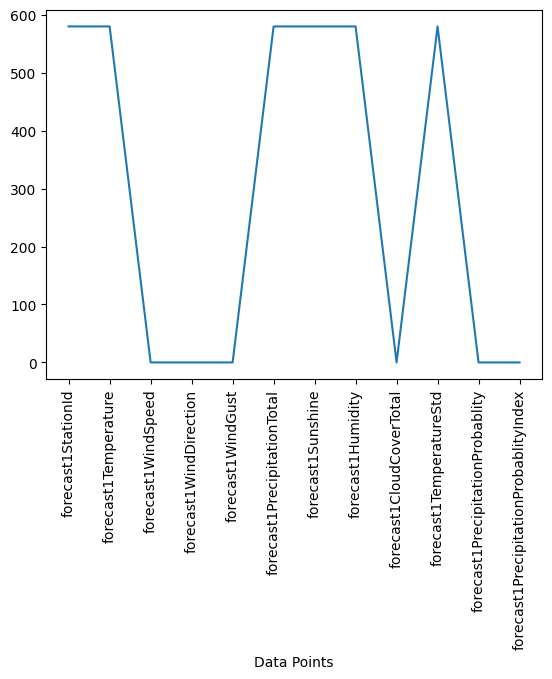

In [56]:
# Define the labels for the x-axis
labels = ['forecast1StationId', 'forecast1Temperature', 'forecast1WindSpeed', 'forecast1WindDirection', 'forecast1WindGust', 'forecast1PrecipitationTotal', 'forecast1Sunshine', 'forecast1Humidity', 'forecast1CloudCoverTotal', 'forecast1TemperatureStd', 'forecast1PrecipitationProbablity', 'forecast1PrecipitationProbablityIndex']

# Plot the data with labels on the x-axis
plt.plot(labels, [len(forecast1StationId), len(forecast1Temperature), len(forecast1WindSpeed), len(forecast1WindDirection), len(forecast1WindGust), len(forecast1PrecipitationTotal), len(forecast1Sunshine), len(forecast1Humidity), len(forecast1CloudCoverTotal), len(forecast1TemperatureStd), len(forecast1PrecipitationProbablity), len(forecast1PrecipitationProbablityIndex)], label='forecast1')
# plt.plot(labels, [len(forecast2StationId), len(forecast2Temperature), len(forecast2WindSpeed), len(forecast2WindDirection), len(forecast2WindGust), len(forecast2PrecipitationTotal), len(forecast2Sunshine), len(forecast2Humidity), len(forecast2CloudCoverTotal), len(forecast2TemperatureStd), len(forecast2PrecipitationProbablity), len(forecast2PrecipitationProbablityIndex)], label='forecast2')

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Add x-axis label
plt.xlabel('Data Points')

# Display the plot
plt.show()


In [60]:
# in the df_important search the Stations-kennung for the Stations_ID and return the breite and länge
coordinates = []
for index, row in df_important.iterrows():
    if row['Stations-kennung'] in all_responses:
        coordinates.append([row['Breite'], row['Länge']])

# make map where I can see all the stations
mymap = folium.Map(location=[0, 0], zoom_start=2)

# Add markers for specific locations
locations = coordinates

for loc in locations:
    folium.Marker(location=loc).add_to(mymap)

# Save the map to an HTML file
mymap.save("map_stations.html")